<a href="https://colab.research.google.com/github/pranjal2234/Stock-Analysis/blob/main/HDFCBANK_share_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing and importing yfinance
!pip install yfinance
import yfinance as yf
import pandas as pd

In [ ]:
#Loading hdfcbank stock market share price
hdfcbank = yf.Ticker("HDFCBANK.NS")
hdfcbank = hdfcbank.history(period= "max")

In [ ]:
hdfcbank.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-08-22,1484.800049,1488.349976,1467.699951,1470.349976,4117033,0.0,0.0
2022-08-23,1453.300049,1475.949951,1450.400024,1465.800049,7483442,0.0,0.0
2022-08-24,1461.900024,1475.500000,1459.199951,1472.849976,6727760,0.0,0.0
2022-08-25,1479.900024,1486.800049,1457.000000,1464.849976,5911520,0.0,0.0
2022-08-26,1472.050049,1481.800049,1461.199951,1465.099976,3853088,0.0,0.0


In [ ]:
#Deleting unnecessary columns
del hdfcbank['Dividends']
del hdfcbank['Stock Splits']
hdfcbank.head()

,Open,High,Low,Close,Volume
Date,,,,,
1996-01-01,2.430058,2.430058,2.345848,2.389958,350000
1996-01-02,2.389958,2.426048,2.365898,2.385948,412000
1996-01-03,2.385947,2.401987,2.365897,2.393967,284000
1996-01-04,2.393968,2.389958,2.357878,2.377928,282000
1996-01-05,2.377927,2.389957,2.365897,2.373917,189000


In [ ]:
hdfcbank.shape

(6707, 5)

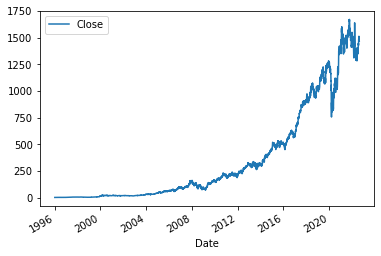

In [ ]:
#Plotting graph between price and date. 
hdfcbank.plot.line(y="Close",use_index= True)

In [ ]:
#Making a target column to check whether the price gone up or not on the next day
hdfcbank["Tomorrow_price"] = hdfcbank["Close"].shift(-1)
hdfcbank["Target"] = (hdfcbank["Tomorrow_price"] > hdfcbank["Close"]).astype(int)
hdfcbank.head()

,Open,High,Low,Close,Volume,Tomorrow_price,Target
Date,,,,,,,
1996-01-01,2.430058,2.430058,2.345848,2.389958,350000,2.385948,0
1996-01-02,2.389958,2.426048,2.365898,2.385948,412000,2.393967,1
1996-01-03,2.385947,2.401987,2.365897,2.393967,284000,2.377928,0
1996-01-04,2.393968,2.389958,2.357878,2.377928,282000,2.373917,0
1996-01-05,2.377927,2.389957,2.365897,2.373917,189000,2.345847,0


In [ ]:
#Importing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=250, min_samples_split=100, random_state=1)

#Splitting the data as training and testing data
train_data = hdfcbank.iloc[:-100]
test_data = hdfcbank.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]

#Training the model
rfc.fit(train_data[predictors], train_data["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=250, random_state=1)

In [ ]:
#Importing precision_score
from sklearn.metrics import precision_score

#Testing the data
predictions = rfc.predict(test_data[predictors])
predictions = pd.Series(predictions, index=test_data.index)
precision_score(test_data["Target"], predictions)

0.5542168674698795

Our model has given a precision rate of 55.42% . That means whenever we are predicting that the price will go up, only 55.42% of the time it is going up.

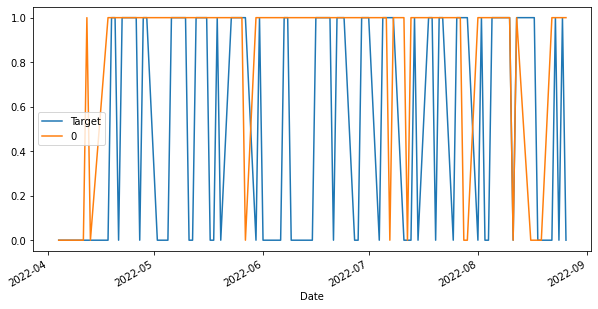

In [ ]:
#plotting target against predictions
combined_data = pd.concat([test_data["Target"], predictions], axis=1)
combined_data.plot(figsize=(10,5))

In [ ]:
rfc = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=40)

In [ ]:
#Wrapping the training and testing process. 
def predict(train_data, test_data, predictors, rfc):
    rfc.fit(train_data[predictors], train_data["Target"])
    predictions = rfc.predict(test_data[predictors])
    predictions = pd.Series(predictions, index=test_data.index, name="Predictions")
    combined_data = pd.concat([test_data["Target"],predictions],axis=1)
    return combined_data

In [ ]:
#Backtesting our data
def backtest(data, rfc, predictors, start=2500, step=250):
    total_predictions = []

    for i in range(start, data.shape[0], step):
        train_data = data.iloc[0:i].copy()
        test_data = data.iloc[i:(i+step)].copy()
        predictions = predict(train_data, test_data, predictors, rfc)
        total_predictions.append(predictions)
    
    return pd.concat(total_predictions)

In [ ]:
predictions = backtest(hdfcbank, rfc, predictors)

In [ ]:
predictions["Predictions"].value_counts()

0    3349
1     858
Name: Predictions, dtype: int64

In [ ]:
#New precision score
precision_score(predictions["Target"], predictions["Predictions"])

0.5466200466200466

In [ ]:
#Increasing the number of predictors by (i)finding the rolling averages in some interval and (ii)finding the ratio of two predictors
intervals = [2,5,20,250,1000]
new_predictors = []

for interval in intervals:
    rolling_averages = hdfcbank.rolling(interval).mean()
    
    ratio_column = f"Close_Ratio_{interval}"
    hdfcbank[ratio_column] = hdfcbank["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{interval}"
    hdfcbank[trend_column] = hdfcbank.shift(1).rolling(interval).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [ ]:
#Dropping the na values
hdfcbank = hdfcbank.dropna()
hdfcbank.head()

,Open,High,Low,Close,Volume,Tomorrow_price,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_20,Trend_20,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1999-11-01,7.583347,7.797731,7.566532,7.654808,935700,7.843970,1,0.991020,0.0,0.967485,1.0,0.927473,9.0,1.276289,121.0,1.593597,444.0
1999-11-02,7.566531,7.902821,7.566531,7.843970,921370,8.007913,1,1.012205,1.0,0.993716,2.0,0.951749,9.0,1.304880,122.0,1.631124,445.0
1999-11-03,7.986895,8.155040,7.986895,8.007913,1522850,7.940654,0,1.010342,2.0,1.019807,2.0,0.971666,10.0,1.329182,122.0,1.663274,445.0
1999-11-04,7.587549,8.070967,7.574939,7.940654,484900,7.940654,0,0.995783,1.0,1.011784,2.0,0.965056,9.0,1.315019,122.0,1.647400,445.0
1999-11-05,7.944858,7.982690,7.864988,7.940654,258150,7.940654,0,1.000000,0.0,1.008004,2.0,0.967378,8.0,1.311962,122.0,1.645500,445.0


In [ ]:
hdfcbank.shape

(5706, 17)

In [ ]:
#Total predictors 
total_predictors = new_predictors+predictors
total_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_20',
 'Trend_20',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000',
 'Close',
 'Volume',
 'Open',
 'High',
 'Low']

In [ ]:
#Training the model with other predictors
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=150, min_samples_split=190, random_state=1)

train_data = hdfcbank.iloc[:-290]
test_data = hdfcbank.iloc[-290:]

rfc.fit(train_data[total_predictors], train_data["Target"])

RandomForestClassifier(min_samples_split=190, n_estimators=150, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

predictions = rfc.predict(test_data[total_predictors])
predictions = pd.Series(predictions, index=test_data.index)
precision_score(test_data["Target"], predictions)

0.6198347107438017

Our precision score has increased up to 61.98% or 62% which earlier was 54.4% . Therefore when are predicting that stock price will go up next day , 62% of the time it is actually going up. 